# Github Data Analysis

* Sean Smith <swsmith@bu.edu> 
* Ann Ming Samborski <asambors@bu.edu>

## Abstract
Programming languages come and go, the popular ones see a meteoric rise but then tend to peter out over the years. We collected data from `github.com`, a popular code sharing platform, in order to measure the relative popularity of programming languages over time. We aim to answer a few questions, What are the "rising stars", programming languages with rapidly increasing popularity? What are the mainstay languages? How have popular languages changed over time?

Other studies have attempted to measure similar metrics. For example the [Stack Overflow Developer](https://stackoverflow.com/insights/survey/2017) survey measured this by surveying ~64,000 developers. We believe that our approach is more accurate as it gets rid of implicit survey bias and looks at hard numbers.

However, we realize that Github is mainly open source software and is not representative of the state of software engineering as a whole. We do believe that software development is moving towards an open model and using Github as a benchmark will become more meaningful over time.

## Dataset
We collected `40,790` repositories (thus far). To do so we used the Github API. At first we wanted to scrape the data so we looked around for the sitemap. We checked `https://github.com/sitemap.xml` and got a 406 (unauthorized), after looking at the `robots.txt` we tried changing our `user-agent` to `Googlebot` to no avail. Next we emailed github and they directed us to their API. The API is rate limited at `5,000` requests per hours so we setup an intelligent script to run it every hour, on the hour, using a crontab on an AWS EC2 instance. 

We don't have a terrible amount of patience and only collecting `2,500` repositories per hour (two requests per repo) was not going to cut it. So we emailed github back and asked for a higher rate. They obliged and raised it to `12,500` requests per hour, this got us `6,250` repos per hour.

Now, I really wasn't going to sit around for 5 hours while this thing ran. So I devised a script that uses [pywren](http://pywren.io/), an open source library that spins up AWS lambda instances on demand. Each lambda instance gets partitioned onto it's own machine (hopefully), so we can run unauthenticated api requests (github gives up 60 per hour) and then collate the results. We ran `600` concurrent processes, each requests the details on `30` repos for a total of `18,000` repos in `60` seconds.


| Name          | Description   |
| ------------- |:--------------|
| name          | Owner/Repository name |
| owner         | Owner name |
| watchers      | Number of watchers |
| stars         | Number of stars |
| forks         | Number of forks |
| type          | Type of account, organization or user |
| issues        | Number of issues|
| created_at    | Date created |
| pushed_at     | Date last pushed |
| updated_at    | Date last updated |
| size          | Size of repo in KB|
| open_issues   | Number of open issues |
| description   | Repositry description |
| num_languages | Number of programming languages |
|language_1     | Most popular language |
|language_1_size| Most popular language size in bytes |
|language_2     | Second most popular language |
|language_2_size| Second most popular language size in bytes |
|language_3     | Third most popular language |
|language_3_size| Third most popular language size in bytes |

## Data Collection Code

In [14]:
import requests
from pprint import pprint
import collections
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

## Data

In [15]:
# Read in data
import pandas as pd
df = pd.read_csv('github_data.csv')

In [16]:
df.head()

,name,owner,watchers,stars,forks,type,issues,created_at,pushed_at,updated_at,size,open_issues_count,description,num_languages,language_1,language_1_size,language_2,language_2_size,language_3,language_3_size
0,mojombo/grit,mojombo,59,1883,451,User,3,2007-10-29T14:37:16Z,2016-08-01T15:17:38Z,2017-04-19T11:01:12Z,7954,3,**Grit is no longer maintained. Check out libg...,1,Ruby,219981.0,NaN,NaN,NaN,NaN
1,wycats/merb-core,wycats,3,407,54,User,0,2008-01-12T05:50:53Z,2008-10-13T02:31:34Z,2017-04-23T16:05:54Z,3462,0,Merb Core: All you need. None you don't.,2,Ruby,948883.0,JavaScript,8925.0,NaN,NaN
2,rubinius/rubinius,rubinius,120,2692,612,Organization,211,2008-01-12T16:46:52Z,2017-04-22T23:00:00Z,2017-04-23T09:34:21Z,162886,211,The Rubinius Language Platform,13,Ruby,7352918.0,C++,2917738.0,C,522111.0
3,mojombo/god,mojombo,104,2036,479,User,112,2008-01-13T05:16:23Z,2017-03-01T00:00:23Z,2017-04-23T14:44:01Z,2639,112,Ruby process monitor,6,Ruby,283939.0,C,9261.0,CSS,6486.0
4,vanpelt/jsawesome,vanpelt,2,36,2,User,0,2008-01-13T06:04:19Z,2008-05-29T20:09:36Z,2017-03-29T18:09:21Z,192,0,Awesome JSON,2,JavaScript,126588.0,Ruby,9677.0,NaN,NaN


In [17]:
df.shape

(137100, 20)

In [18]:
df.type.value_counts()

User            130069
Organization      7031
Name: type, dtype: int64

## Most Popular Programming Language

In [19]:
df.language_1.value_counts()

Ruby                   36351
JavaScript             15032
Python                 11333
PHP                     7484
Java                    6384
C                       6070
Perl                    5027
C++                     4391
Objective-C             2852
C#                      2158
Shell                   1999
Emacs Lisp              1802
VimL                    1254
ActionScript            1072
Erlang                   976
Haskell                  900
Scala                    774
Clojure                  718
Lua                      677
Common Lisp              520
HTML                     389
CSS                      376
Groovy                   356
Scheme                   268
Vim script               181
OCaml                    170
Go                       168
Visual Basic             144
Objective-J              121
TeX                      107
                       ...  
Dart                       1
POV-Ray SDL                1
Nim                        1
Augeas        

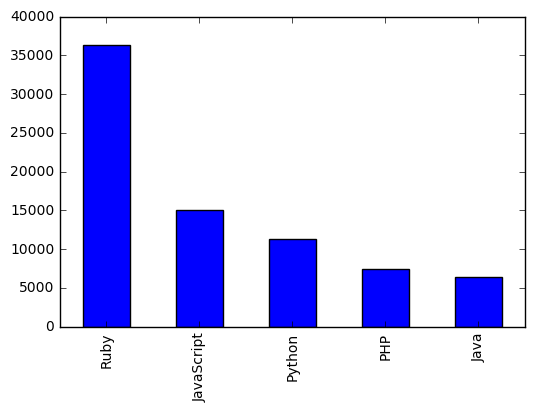

In [20]:
df.language_1.value_counts()[:5].plot.bar()

In [21]:
ruby_popularity = df[df.language_1 == 'Ruby'].filter(['language_1_size', 'created_at'])

Min: 2007-10-29T14:37:16Z
Max: 2010-06-24T18:44:50Z


(0, 20000000)

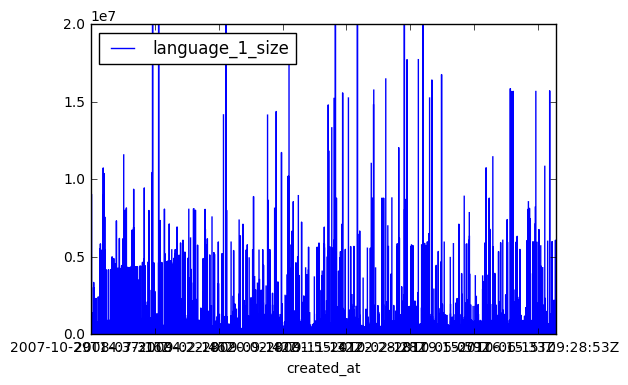

In [22]:
# import matplotlib.pyplot as plt
# axes = plt.subplot()
print("Min: %s" % ruby_popularity.created_at.min())
print("Max: %s" % ruby_popularity.created_at.max())

# bins = ruby_popularity.created_at.hist(bins=10)
# bins[0][0].x_label('created_at')
plt = ruby_popularity.plot(x='created_at', y='language_1_size')
plt.set_ylim([0,20000000])

# Forks vs Stars

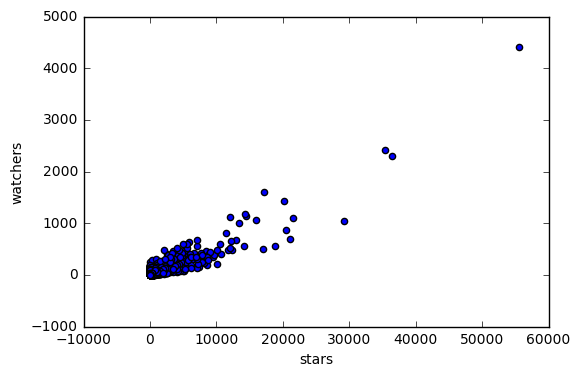

In [33]:
df.plot.scatter(x='stars', y='watchers')

KeyError: 'pushed_at'

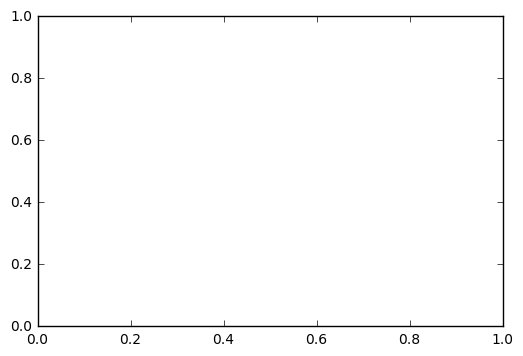

In [36]:
# Creation date vs stars
                                                                                          